<a href="https://colab.research.google.com/github/aditya-shriwastava/ai-notebooks/blob/master/FasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Docs

## Faster RCNN

### PreProcess
### Common
> **Input:** image, `bboxs_gt`<br/>
> **Output:** `image` (i.e. pre-processed image), `bboxs_gt` (i.e. pre-processed `bboxs_gt`)

1. Normalize the input image with mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
2. Rescale the normalized image such that shorter side in 300 pixels and return `image`.
3. Rescale the `bboxs_gt` according to the image rescale and return `bboxs_gt`.

### Backbone
### Common
> **Input:** `image`<br/>
> **Output:** `feature_map`, `subsampling_ratio`

1. Pass `image` to resnet50 backbone (i.e. upto layer3) and return output as `feature_map`.
2. if `image.shape` = (C,H,W) and `feature_map.shape` = (Cf,Hf,Wf) return `subsampling_ratio` as (Hf/H, Wf/W)

### RPN
#### Common
> **Input:** `feature_map`<br/>
> **Output:** `objectness_score`, `rois_offset`

1. Pass `feature_map` to 3x3 convolution to reduce depth to 512 while conserving Hf and Wf.
   - stride=1 and padding=1
   - output: `feature_map` of shape (512, Hf, Wf)
2. Pass above output to two 1x1 convolution to get `objectness_score` and `rois_offset`.
   1. `objectness_score`: (2 x 9, Hf, Wf)
     - Number of anchors: 9
     - (object score + not object score) per anchors: 2
   2. `rois_offset`: (4 x 9, Hf, Wf)
     - Number of anchors: 9
     - Number of param for roi offset of 1 anchors: 4
3. Reshape `objectness_score` and `rois_offset` to `(Hf*Wf*9,2)` and `(Hf*Wf*9,4)` respectively.

#### Training
> **Input:** `image_boundaries`, `objectness_score`, `rois_offset`, `bboxs_gt`<br/>
> **Output:** `cls_loss`, `reg_loss`

1. Filter out rois which goes beyond the boundaries of `image`.
2. Based on IoU (Intersection over Union) of rois with `bboxs_gt` classify rois into positive and negative.
    1. **Positive:** if IoU > 0.5
    2. **Negative:** if IoU < 0.1
3. Sample 256 rois with `#rois_positive/#rois_negative` as close to 1 a possible.
4. Calculate and return `cls_loss` as cross-entropy loss over objectness score with positive being object and negative not being object.
5. Calculate `rois_positive_gt = [bbox_in_gt_with_maxIoU(roi_positive, bboxs_gt) for roi_positive in rois_positive]`.
6. Calculate and return `reg_loss` as smooth L1 loss of (`rois_offset_positive` - `rois_offset_positive_gt`)

#### Inference
> **Input:** `image_boundaries`, `objectness_score`, `rois_offset`<br/>
> **Output:** `rois`

1. Sort rois based on objectness score.
2. Filter out rois using NMS whith IoU threshold: 0.6
3. Keep top N=500 proposals.
4. Clip filtered rois to `image` boundaries and return the clipped rois.

### FastRCNN
#### Common
> **Input:** rois, `feature_map`, `subsampling_ratio`<br/>
> **Output:** `classification_score`, `detections_offset`

1. Perform ROI Pooling with rois on `feature_map` and obtain `rois_fm` (rois feature map).
2. pass `rois_fm` to two fully connected layer of dimension 512.
3. Pass the output of above to two different fc layer:
    1. 21 dimensional to get `classification_score`.
    2. 21 * 4 dimensional to get `detections_offset`.

#### Training
> **Input:** `classification_score`, `detections_offset`, `bboxs_gt`, `labels_gt`<br/>
> **Output:** `cls_loss`, `reg_loss`

1. Based on IoU (Intersection over Union) of rois with `bboxs_gt` classify rois into positive and negative.
    1. **Positive:** if IoU > 0.5
    2. **Negative:** if 0.1 < IoU < 0.5
2. Randomly sample a mini batch of size 64 in which we have up to 25% positive and 75% negative.
3. Calculate
    1. `detections_positive_gt_bboxs = [bbox_in_gt_with_maxIoU(detection_positive, bboxs_gt) for detection_positive in detections_positive]`
    2. `detections_positive_gt_labels = [labels_with_maxIoU(detection_positive, bboxs_gt) for detection_positive in detections_positive]` 
5. Calculate and return `cls_loss` as cross-entropy loss over `classification_score` with positive being object with `detections_positive_gt_labels` as labels and negative being background.
6. Calculate and return `reg_loss` as smooth L1 loss of (`detection_offset_positive` - `detection_offset_positive_gt_bboxs`)

#### Inference
> **Input:** `image_boundaries`, `classification_score`, `detections_offset`<br/>
> **Output:** detections, labels

1. Obtain detections with max classification score.
2. Filter out detections in which background has max classification score.
3. Apply class based NMS.
    1. Group the detections by class
    2. Sort them by probability.
    3. Apply NMS to each group independently.
4. Filter out detections that has probability below a certain threshold.
5. clip detections to `image_boundaries`.

### FasterRCNN
#### Training
> **Input:** image, `bboxs_gt`, `labels_gt`<br/>
> **Output:** `rpn_cls_loss`, `rpn_reg_loss`, `rcnn_cls_loss`, `rcnn_reg_loss`

1. `image, bboxs_gt = PreProcess.Common(image, bboxs_gt)`
2. `feature_map, subsampling_ratio = Backbone.Common(image)`
3. `objectness_score, rois_offset = RPN.Common(feature_map)`
4. `rpn_cls_loss, rpn_reg_loss = RPN.Training(image.shape[2:], objectness_score, rois_offset, bboxs_gt)`
5. `rois = RPN.Inference(image.shape[2:], objectness_score, rois_offset)`
6. `classification_score, detections_offset = FastRCNN.Common(rois, feature_map, subsampling_ratio)`
7. `rcnn_cls_loss, rcnn_reg_loss = FasterRCNN.Training(classification_score, detections_offset, bboxs_gt, labels_gt)`

#### Inference
> **Input:** image<br/>
> **Output:** detections, labels

1. `image, bboxs_gt = PreProcess.Common(image, bboxs_gt)`
2. `feature_map, subsampling_ratio = Backbone.Common(image)`
3. `objectness_score, rois_offset = RPN.Common(feature_map)`
5. `rois = RPN.Inference(image.shape[2:], objectness_score, rois_offset)`
6. `classification_score, detections_offset = FastRCNN.Common(rois, feature_map, subsampling_ratio)`
7. `detections, labels = FastRCNN.Inference(image.shape[2:], classification, detections_offset)`

# Implementation

In [1]:
#@title pip3 install requirements
!pip3 install pytest

## Files

### bbox_utils

#### bbox_utils.py

In [2]:
%%file bbox_utils.py

import torch
import torchvision
import random

def filter_cross_boundary(bboxs, bbox_within):
  """
  Args:
    bboxs: bboxs tensor in minmax format of shape (N,4) to filter.
    bbox_within: bbox tensor in minmax format of shape (4,) within
    which bboxs should be.
  Returns:
    A tensor of index of bboxs which are within bbox_within.
  """
  N = bboxs.shape[0]
  corner_offset = bboxs - bbox_within
  iswithin = torch.logical_and(
    (corner_offset[:,:2] >= 0).all(axis=1),
    (corner_offset[:,2:] <= 0).all(axis=1)
  )
  return torch.arange(N)[iswithin]

def filter_iou(bboxs1, bboxs2, min_iou=0, max_iou=1):
  """
  Args:
    bboxs1: bboxs tensor in xyxy format of shape (N,4)
    bboxs2: bboxs tensor in xyxy format of shape (M,4)
  Returns:
    A tensor of index of bboxs1 such that min_iou <= iou(bboxs[i], bboxs2) <= max_iou
    for i in [1,2, ..., N] and argmax_i(iou(bboxs[i], bboxs2))
  """
  N = bboxs1.shape[0]
  iou_max = torchvision.ops.box_iou(bboxs1, bboxs2).max(axis=1)[0]
  iswithin = torch.logical_and(
    (iou_max >= min_iou),
    (iou_max <= max_iou)
  )
  return torch.arange(N)[iswithin]

def sample_bboxs(bboxs, max_bboxs):
  N = bboxs.shape[0]
  if N > max_bboxs:
    index = random.sample(range(N),max_bboxs)
    return bboxs[index], torch.tensor(index)
  else:
    return bboxs, torch.arange(N)

def get_bboxs(bboxs_offset, anchors):
  """Reff https://arxiv.org/pdf/1506.01497.pdf eq2
  Args:
    bboxs_offset: tensor of shape (N,4) representing offset of bboxs in
      ctrwh format form anchors.
    anchors: tensor of shape (N,4) representing anchors in ctrwh format
  Returns:
    A tensor of shape (N,4) representing bboxs
  """
  bboxs = torch.zeros_like(bboxs_offset)

  bboxs[:,0] = anchors[:,0] + (bboxs_offset[:,0] * anchors[:,2])
  bboxs[:,1] = anchors[:,1] + (bboxs_offset[:,1] * anchors[:,3])
  bboxs[:,2] = anchors[:,2] * torch.exp(bboxs_offset[:,2])
  bboxs[:,3] = anchors[:,3] * torch.exp(bboxs_offset[:,3])
  return bboxs

def get_bboxs_offset(bboxs, anchors):
  """Reff https://arxiv.org/pdf/1506.01497.pdf eq2
  Args:
    bboxs: tensor of shape (N,4) representing bboxs in ctrwh format.
    anchors: tensor of shape (N,4) representing anchors in ctrwh format
  Returns:
    A tensor of shape (N,4) representing bboxs_offset
  """
  bboxs_offset = torch.zeros_like(bboxs)

  bboxs_offset[:,0] = (bboxs[:,0] - anchors[:,0]) / anchors[:,2]
  bboxs_offset[:,1] = (bboxs[:,1] - anchors[:,1]) / anchors[:,3]
  bboxs_offset[:,2] = torch.log(bboxs[:,2] / anchors[:,2])
  bboxs_offset[:,3] = torch.log(bboxs[:,3] / anchors[:,3])
  return bboxs_offset

def get_anchors(
    Hf, Wf,
    ratios = torch.tensor([0.5, 1.0, 2.0]),
    scale = torch.tensor([4.0, 8.0, 16.0]),
    base_size = 16,
    stride = 10):
  """
  Args:
    Hf: Height of feature_map we want anchors for.
    Wf: Width of feature_map we want anchors for.
    ratios: tensor of shape (3,) representing aspect ratios of anchors.
    scale: tensor of shape (3,) representing scale of anchors.
    base_size: base size of the anchor which will be scaled.
    stride: distance by which anchors will be shifted along height and
      weidth of feature_map.
  Returns:
    A tensor of shape (Hf*Wf*9,4) representing 9 anchors in cxcywh format at
    each pixel position.
  """
  def get_base_anchors(ratios, scale, base_size):
    """
    Args:
      ratios: tensor of shape (3,) representing aspect ratios of anchors.
      scale: tensor of shape (3,) representing scale of anchors.
      base_size: base size of the anchor which will be scaled.
    Returns:
      A tensor of shape (9,4) representing 9 anchors (3 ratios * 3 scale)
      in cxcywh format.
    """
    # 1. base_anchors(1,4) in ctrwh format
    base_anchors = torch.tensor([[
      (base_size-1)/2,
      (base_size-1)/2,
      base_size,
      base_size
    ]])

    # 2. Apply ratios to base_anchors(1,4) to generate base_anchors(3,4)
    size = base_anchors[0,2] * base_anchors[0,3]
    base_anchors = base_anchors.repeat(3,1)
    heights = torch.sqrt(size * ratios)
    widths = heights/ratios
    base_anchors[:,2] = heights
    base_anchors[:,3] = widths

    # 3. Apply scale to base_anchors(3,4) to generate base_anchors(9,4)
    base_anchors = base_anchors.repeat(1,3).view(9,4)
    base_anchors[:,2:4] *= scale.repeat(3).view(9,1).repeat(1,2)

    return torch.round(base_anchors)

  anchors = get_base_anchors(ratios, scale, base_size)\
    .view(-1)\
    .unsqueeze(0).repeat(Wf,1)\
    .unsqueeze(0).repeat(Hf,1,1)\
    .view(Hf,Wf,9,4)

  shift_x = (torch.arange(0, Wf) * stride).repeat(Hf,1)\
    .repeat(9,1,1).permute(1,2,0)
  shift_y = (torch.arange(0, Hf) * stride).unsqueeze(1).repeat(1,Wf)\
    .repeat(9,1,1).permute(1,2,0)

  anchors[:,:,:,0] += shift_x
  anchors[:,:,:,1] += shift_y

  return anchors.reshape(-1,4)

Writing bbox_utils.py


#### test_bbox_utils.py

In [3]:
%%file test_bbox_utils.py

import pytest
import torch

from bbox_utils import *

class TestFilterCrossBoundary:
  @pytest.fixture
  def bboxs(self):
    bboxs = torch.tensor([
        [0, 0, 99, 99],
        [50, 50, 99, 99],
        [-10, 10, 20, 34],
        [10, -10, 20, 34],
        [0, 0, 0, 0],
        [99, 99, 99, 99],
        [0, 0, 199, 199],
    ], dtype=torch.float32)
    return bboxs

  def test(self, bboxs):
    bbox_within = torch.tensor([0, 0, 99, 99])
    iswithin = torch.tensor(
      [True, True, False, False, True, True, False]
    )
    index = filter_cross_boundary(bboxs, bbox_within)
    assert (bboxs[index]- bboxs[iswithin]).mean() < 0.01

class TestFilterIou:
  @pytest.fixture
  def bboxs1(self):
    bboxs1 = torch.tensor([
        [0, 0, 99, 99],
        [50, 50, 99, 99],
        [75, 25, 124, 74],
        [75, 75, 124, 124],
        [75, -25, 124, 24]
    ], dtype=torch.float32)
    return bboxs1

  @pytest.fixture
  def bboxs2(self):
    bboxs2 = torch.tensor([
        [0, 0, 99, 99],
        [50, 50, 99, 99]
    ], dtype=torch.float32)
    return bboxs2

  # torchvision.ops.box_iou(bboxs1, bboxs2)
  #   [[1.0000, 0.2450],
  #    [0.2450, 1.0000],
  #    [0.1067, 0.1363],
  #    [0.0495, 0.1363],
  #    [0.0495, 0.0000]])

  def test_case1(self, bboxs1, bboxs2):
    index = filter_iou(bboxs1, bboxs2, min_iou=0, max_iou=1)
    iswithin = torch.tensor(
      [True, True, True, True, True]
    )
    assert (bboxs1[index] - bboxs1[iswithin]).mean() < 0.01

  def test_case2(self, bboxs1, bboxs2):
    index = filter_iou(bboxs1, bboxs2, min_iou=0.1)
    iswithin = torch.tensor(
      [True, True, True, True, False]
    )
    assert (bboxs1[index] - bboxs1[iswithin]).mean() < 0.01

  def test_case3(self, bboxs1, bboxs2):
    index = filter_iou(bboxs1, bboxs2, max_iou=0.5)
    iswithin = torch.tensor(
      [False, False, True, True, True]
    )
    print(index)
    assert (bboxs1[index] - bboxs1[iswithin]).mean() < 0.01

class TestSampleBboxs:
  @pytest.fixture
  def bboxs(self):
    bboxs = torch.tensor([
        [0, 0, 99, 99],
        [50, 50, 99, 99],
        [-10, 10, 20, 34],
        [10, -10, 20, 34],
        [0, 0, 0, 0],
        [99, 99, 99, 99],
        [0, 0, 199, 199],
    ], dtype=torch.float32)
    return bboxs

  def test_case1(self, bboxs):
    bboxs_, index = sample_bboxs(bboxs, max_bboxs=3)
    assert bboxs_.shape[0] == 3
    assert index.shape[0] == 3

  def test_case2(self, bboxs):
    bboxs_, index = sample_bboxs(bboxs, max_bboxs=10)
    assert bboxs_.shape[0] == bboxs.shape[0]
    assert index.shape[0] == bboxs.shape[0]

class TestGetAnchors:
  def test(self):
    anchors = get_anchors(2,3)
    print(anchors)
    assert anchors.shape == (9*6,4)

Writing test_bbox_utils.py


#### Run tests

In [4]:
!python -m pytest test_bbox_utils.py

============================= test session starts ==============================
platform linux -- Python 3.7.12, pytest-3.6.4, py-1.11.0, pluggy-0.7.1
rootdir: /content, inifile:
plugins: typeguard-2.7.1
collected 7 items                                                              

test_bbox_utils.py .......                                               [100%]

=========================== 7 passed in 8.20 seconds ===========================


### voc_utils

In [5]:
%%file voc_utils.py

import torch

voc_labels = ("background",
  "aeroplane", "bicycle", "bird", "boat","bottle",
  "bus", "car", "cat", "chair", "cow",
  "diningtable", "dog", "horse", "motorbike", "person",
  "pottedplant", "sheep", "sofa", "train", "tvmonitor"
)

voc_label_to_id = {k: v+1 for v, k in enumerate(voc_labels)}
voc_label_to_id['background'] = 0

def get_bboxs_and_labels(meta):
  objects = meta['annotation']['object']
  bboxs = []
  labels = []
  ids = []
  for object_ in objects:
    labels.append(object_['name'][0])
    ids.append(voc_label_to_id[labels[-1]])
    xmin = int(object_['bndbox']['xmin'][0])
    ymin = int(object_['bndbox']['ymin'][0])
    xmax = int(object_['bndbox']['xmax'][0])
    ymax = int(object_['bndbox']['ymax'][0])
    bboxs.append([xmin, ymin, xmax, ymax])
  return torch.tensor(bboxs, dtype=torch.float32), labels, ids

Writing voc_utils.py


## main

In [6]:
#@title imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from bbox_utils import *
from voc_utils import *

%reload_ext autoreload
%autoreload 2

In [7]:
#@title Load VOC data
train_data = torchvision.datasets.VOCDetection(
  root="./datasets", year="2012",
  image_set='train', download=True,
  transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
  ])
)
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)

val_data = torchvision.datasets.VOCDetection(
  root="./datasets", year="2012",
  image_set='val', download=True,
  transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
  ])
)
val_loader = DataLoader(val_data, batch_size=1, shuffle=False)

  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./datasets/VOCtrainval_11-May-2012.tar to ./datasets
Using downloaded and verified file: ./datasets/VOCtrainval_11-May-2012.tar
Extracting ./datasets/VOCtrainval_11-May-2012.tar to ./datasets


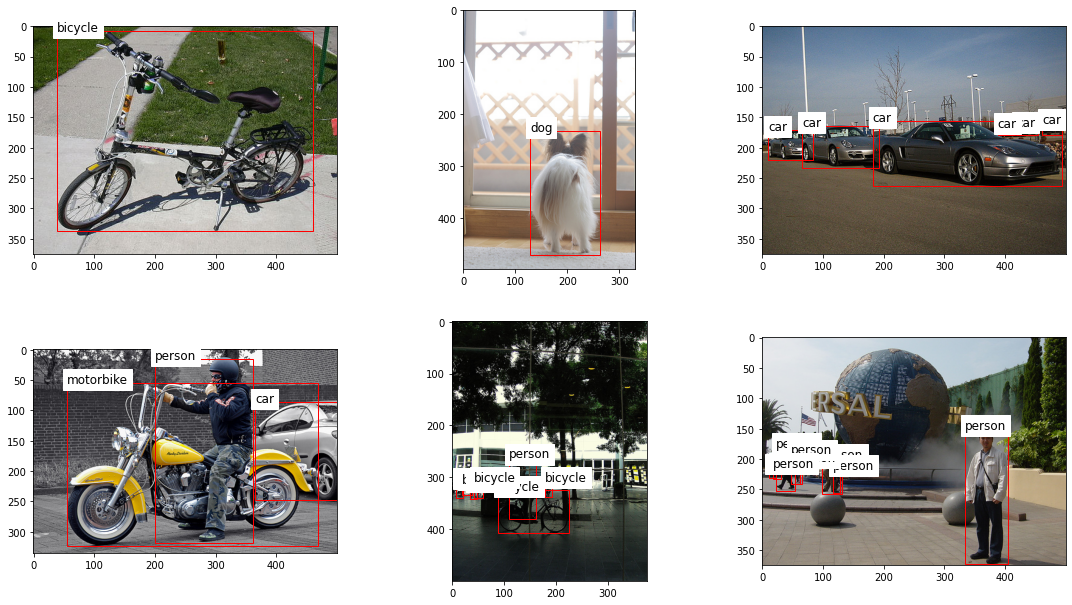

In [8]:
#@title Show sample train data
def disp(img, bboxs, labels, ax=None):
  img = torchvision.transforms.ToPILImage()(img)
  if ax is None:
    fig, ax = plt.subplots()
  ax.imshow(img)
  for bbox, label in zip(bboxs, labels):
    bbox = torchvision.ops.box_convert(
      bbox.unsqueeze(0),
      in_fmt='xyxy',
      out_fmt='xywh'
    ).squeeze()
    ax.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none'))
    ax.text(bbox[0], bbox[1], label, fontsize = 12, color='black', backgroundcolor='white')
  if ax is None:
    plt.show()

fig, axarr = plt.subplots(2,3)
fig.set_size_inches(18.5, 10.5)
for index, (img, meta) in enumerate(train_loader):
  i = index // 3
  j = index - (i * 3)
  bboxs, labels, ids = get_bboxs_and_labels(meta)
  disp(img[0], bboxs, labels, ax=axarr[i,j])
  if index == 5:
    break
plt.show()

### Models

#### RPN

In [ ]:
class RPN(nn.Module):
  def __init__(self, feature_map_channels):
    super().__init__()
    self.lower_dim_mapping = nn.Sequential(
        nn.Conv2d(feature_map_channels, 512, 3, stride=1, padding=1),
        nn.ReLU()
    )
    self.objectness_score = nn.Conv2d(512, 9*2, 1, stride=1, padding=0)
    self.rois_offset= nn.Conv2d(512, 9*4, 1, stride=1, padding=0)
    self.reg_loss = nn.SmoothL1Loss()
    self.cls_loss = nn.CrossEntropyLoss()
    
  def forward(self, feature_map, image_boundaries, bboxs_gt=None):
    """
    Args:
      feature_map: tensor of shape (1, Cf, Hf, Wf).
      image_boundaries: tupel (H, W) giving the boundaries of image.
      bboxs_gt: tensor of shape (M,4) in xyxy format representing
        M ground truth bboxs on the image corresponding to the given
        feature_map.
    Returns:
      rois: tensor of shape (N,4) representing predicted rois within the image
        in xyxy format.
      reg_loss: regression loss returned only during training.
      cls_loss: classification loss returned only during training.
    """
    H, W = image_boundaries
    Hf, Wf = feature_map.shape[2:]

    # 1. forward pass
    feature_map = self.lower_dim_mapping(feature_map) 
    objectness_score = self.objectness_score(feature_map)
    rois_offset = self.rois_offset(feature_map)

    # 2. reshape
    objectness_score = objectness_score.view(9*2,Hf,Wf).permute((1,2,0)).reshape(-1,2)
    rois_offset = rois_offset.view(9*4,Hf,Wf).permute((1,2,0)).reshape(-1,4)

    # 3. get anchors
    anchors = self.get_anchors(Hf,Wf)

    # 4. get rois (in xyxy format) from rois_offset.
    rois = get_bboxs(rois_offset, anchors)
    rois = torchvision.ops.box_convert(rois, in_fmt='cxcywh', out_fmt='xyxy')

    # 5. Filter out rois using NMS whith iou threshold: 0.6 and select top 500
    index = torchvision.ops.batched_nms(
      rois,
      objectness_score[:,0],
      torch.zeros(Hf*Wf*9),
      iou_threshold = 0.6
    )[:500]

    # 6. Clip rois to image boundaries
    rois_clipped = torchvision.ops.clip_boxes_to_image(
      rois[index],
      image_boundaries
    )

    if not self.training:
      return rois_clipped
    else:
      ## 1. Filter out rois which goes beyond the boundaries of image.
      index = filter_cross_boundary(
        rois,
        torch.tensor([0, 0, H, W], dtype=torch.float32)
      )

      ## 2. Based on iou of rois with bboxs_gt classify rois
      #     into positive and negative.
      index_positive = index[torch.hstack((
        filter_iou(rois[index], bboxs_gt, min_iou=0.5),
        torchvision.ops.box_iou(
          rois[index],
          bboxs_gt).max(axis=1)[0].max(axis=0)[1]
      ))]
      index_negative = index[filter_iou(rois[index], bboxs_gt, max_iou=0.1)]

      ## 3. Sample 256 rois with #rois_positive/#rois_negative
      #     as close to 1 a possible.
      index_positive = index[sample_bboxs(
        rois[index_positive],
        max_bboxs = 128
      )]

      index_negative = index[sample_bboxs(
        rois[index_negative],
        max_bboxs = 256 - index_positive.shape[0]
      )]

      ## 4. Calculate cls_loss
      target = torch.hstack((
        torch.zeros(index_negative.shape[0], dtype=torch.long),
        torch.ones(index_positive.shape[0], dtype=torch.long)    
      ))
      objectness_score_training = torch.vstack((
        objectness_score[index_negative],
        objectness_score[index_positive]
      ))
      cls_loss = self.cls_loss(
          objectness_score_training,
          target
      )

      ## 5. Calculate index_positive_gt
      index_positive_gt = torchvision.ops.box_iou(
        rois[index_positive],
        bboxs_gt
      ).max(axis=1)[1]

      ## 6. Calculate reg_loss
      reg_loss = self.reg_loss(
        rois_offset[index_positive],
        get_bboxs_offset(
          torchvision.ops.box_convert(
            bboxs_gt[index_positive_gt],
            in_fmt='xyxy',
            out_fmt='cxcywh'
          ),
          anchors[index_positive]
        )
      )

      return rois_clipped,reg_loss, cls_loss

#### Fast RCNN

In [ ]:
class FastRCNN(nn.Module):
  def __init__(self, feature_map_channels):
    super().__init__()
    self.fc = nn.Sequential(
      nn.Linear(feature_map_channels*7*7, 512),
      nn.ReLU(),
      nn.Linear(512, 512),
      nn.ReLU()
    )
    self.cls_score = nn.Linear(512, 21)
    self.detections_offset = nn.Linear(512, 21 * 4)
    self.reg_loss = nn.SmoothL1Loss()
    self.cls_loss = nn.CrossEntropyLoss()

  def forward(self, rois, feature_map, image_boundaries, gt=None):
    """
    Args:
      rois: tensor of shape (N,4) representing region of interests within the 
        image in xyxy format.
      feature_map: tensor of shape (1, Cf, Hf, Wf).
      image_boundaries: tupel (H, W) giving the boundaries of image.
      gt: tuple (bboxs_gt, labels_gt)
        bboxs_gt: tensor of shape (M,4) in xyxy format representing
          M ground truth bboxs on the image corresponding to the given
          feature_map.
        labels_gt: tensor of shape (M,) representing labels corresponding to
          bboxs_gt.
    Returns (During Training):
      reg_loss: regression loss
      cls_loss: classification loss
    Returns (During Evaluation):
      detections: tensor of shape (L,4) representing L detections on the
        image corresponding to the feature_map.
      labels: tensor of shape (L,) representing predicted labels corresponding
      to detections.
    """
    H, W = image_boundaries
    Cf, Hf, Wf = feature_map.shape[1:]

    # 1. ROI Projection
    rois_proj = rois * torch.tensor([Wf/W,Hf/H,Wf/W,Hf/H])
    
    # 2. ROI Pooling
    rois_fm = torchvision.ops.roi_pool(
      feature_map,
      [rois_proj],
      7
    ).reshape(-1,Cf*7*7)

    # 3. forward pass
    rois_fm = self.fc(rois_fm)
    cls_score = self.cls_score(rois_fm)
    detections_offset = self.detections_offset(rois_fm).reshape(-1,21,4)

    if self.training:
      bboxs_gt, labels_gt = gt
      
      ## 1. Based on iou of rois with bboxs_gt classify rois into
      #     positive and negative.
      index_positive = filter_iou(rois, bboxs_gt, min_iou=0.5)
      index_negative = filter_iou(rois, bboxs_gt, min_iou=0.1, max_iou=0.5)

      ## 2. Randomly sample a mini batch of size 64 in which we have up to
      #     25% positive and 75% negative.
      index_positive = index_positive[sample_bboxs(
        rois[index_positive],
        max_bboxs = 16
      )]

      index_negative = index_negative[sample_bboxs(
        rois[index_negative],
        max_bboxs = 64 - index_positive.shape[0]
      )]

      ## 3. Calculate index_positive_gt
      index_positive_gt = torchvision.ops.box_iou(
        rois[index_positive],
        bboxs_gt
      ).max(axis=1)[1]

      ## 4. Calculate cls_loss
      target = torch.hstack((
        torch.zeros(index_negative.shape[0], dtype=torch.long),
        labels_gt[index_positive_gt]    
      ))
      cls_score_training = torch.vstack((
        cls_score[index_negative],
        cls_score[index_positive]
      ))
      cls_loss = self.cls_loss(
          cls_score_training,
          target
      )

      ## 6. Calculate reg_loss
      reg_loss = self.reg_loss(
        detections_offset[index_positive][
          torch.arange(len(index_positive)),
          labels_gt[index_positive_gt]
        ],
        get_bboxs_offset(
          torchvision.ops.box_convert(
            bboxs_gt[index_positive_gt],
            in_fmt='xyxy',
            out_fmt='cxcywh'
          ),
          rois[index_positive]
        )    
      )

      return reg_loss, cls_loss
    else:
      ## 1. Obtain detections and labels with max cls score
      scores, labels = cls_score.max(dim=1)
      detections = get_bboxs(
        detections_offset[
          torch.arange(len(detections_offset)),
          labels
        ],
        rois
      )

      ## 2. Filter out detections with background as label
      index = torch.arange(len(detections))[labels != 0]

      ## 3. Apply class based NMS to filter out overlapping detections
      index = index[torchvision.ops.batched_nms(
        detections[index],
        scores[index],
        labels[index],
        iou_threshold = 0.6
      )]

      ## 4. Filter out detections that has probability below 0.8
      index = index[F.softmax(cls_score[index], dim=1).max(dim=1)[0] > 0.8]

      ## 5. clip detections to image_boundaries
      detections_clipped = torchvision.ops.clip_boxes_to_image(
        detections[index],
        image_boundaries
      )

      return detections_clipped, labels[index]

#### Faster RCNN

In [ ]:
class FasterRCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.resnet50 = torchvision.models.resnet50(pretrained=True)
    self.backbone = nn.Sequential(
      self.resnet50.conv1,
      self.resnet50.bn1,
      self.resnet50.relu,
      self.resnet50.maxpool,
      self.resnet50.layer1,
      self.resnet50.layer2,
      self.resnet50.layer3
    )

    feature_map_channels = 1024
    self.rpn = RPN(feature_map_channels)
    self.rcnn = FastRCNN(feature_map_channels)
    
  def forward(self, img, gt=None):
    """
    Args:
      img: tensor of shape (1,C,H,W) representing 1 image
      gt: tuple (bboxs_gt, labels_gt)
        bboxs_gt: tensor of shape (M,4) in xyxy format representing
          M ground truth bboxs on the image corresponding to the given
          feature_map.
        labels_gt: tensor of shape (M,) representing labels corresponding to
          bboxs_gt.
    """
    # 1. Pre-Process
    if self.training:
      img, gt[0] = self.preprocess(img, gt[0])
    else:
      img = self.preprocess(img)[0]

    # 2. Pass img to resnet50 backbone
    feature_map = self.backbone(img)
    image_boundaries = img.shape[2:]

    # 3. RPN forward pass
    if self.training:
      rois, rpn_reg_loss, rpn_cls_loss = self.rpn(
        feature_map, image_boundaries, bboxs_gt=gt[0])
    else:
      rois = self.rpn(feature_map, image_boundaries)

    # 4. FastRCNN forward pass
    if self.training:
      rcnn_reg_loss, rcnn_cls_loss = self.rcnn(rois, feature_map, image_boundaries, gt=gt)
    else:
      detections, labels = self.rcnn(rois, feature_map, image_boundaries)

    # 5. Return
    if self.training:
      return rpn_reg_loss, rpn_cls_loss, rcnn_reg_loss, rcnn_cls_loss
    else:
      return detections, labels

  def preprocess(self, img, bboxs_gt=None):
    # 1. Resize the Image 
    _, _, H, W = img.shape
    img = torchvision.transforms.Resize(300)(img)

    # 2. Resize the bboxs according to image resize
    if bboxs_gt is not None:
      _, _, H_, W_ = img.shape
      bboxs_gt = bboxs_gt * torch.tensor([W_/W, H_/H, W_/W, H_/H], dtype=torch.float32)

    # 3. Normalize the the image
    normalize = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    img = normalize(img)

    return img, bboxs_gt

### Training

['diningtable', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'tvmonitor']
<class 'list'>


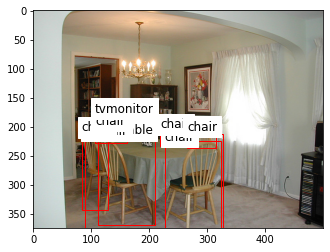

In [ ]:
for img, meta in train_loader:
  bboxs, labels, ids = get_bboxs_and_labels(meta)
  print(labels)
  print(type(ids))
  disp(img[0], bboxs, labels)
  img, bboxs = preprocess(img, bboxs)

  rpn = RPN()
  fast_rcnn = FastRCNN()
  faster_rcnn = FasterRCNN()
  
  feature_map = faster_rcnn(img)
  _,_,_,rois = rpn(feature_map, img.shape)
  fast_rcnn(feature_map, img.shape, rois)
  # print(rois[:5])
  # reg_loss, cls_loss = rpn.get_losses(feature_map, img.shape, bboxs)
  # print(reg_loss, cls_loss)
  break

### Inference